In [1]:
# Standard imports
from pathlib import Path
import pandas as pd
import numpy as np

# Import our refactored modules
from athletes_brain.fig1 import (
    Fig1Config,
    AthletesBrainDataLoader,
    GroupComparison,
    BrainPlotter,
    generate_figure1,
)

# Import specific functions for focused analysis
from athletes_brain.fig1.main import analyze_specific_comparison, get_most_significant_regions

2025-09-09 12:00:59.494 | INFO     | athletes_brain.config:<module>:11 - PROJ_ROOT path is: /home/galkepler/Projects/athletes_brain


In [2]:
# Initialize configuration
config = Fig1Config()

config.METRICS = ["gm_vol", "adc"]
# Set up matplotlib configuration for consistent plots
config.setup_matplotlib_config()

# Display configuration
print(f"Atlas: {config.ATLAS}")
print(f"Metrics: {config.METRICS}")
print(
    f"Group labels: {config.CLIMBER_GROUP_LABEL}, {config.BJJ_GROUP_LABEL}, {config.CONTROL_GROUP_LABEL}"
)
print(f"P-value threshold: {config.P_THRESHOLD}")
print(f"Visualization range: [{config.VMIN}, {config.VMAX}]")

Atlas: schaefer2018tian2020_400_7
Metrics: ['gm_vol', 'adc']
Group labels: Climbing, Bjj, Control
P-value threshold: 0.05
Visualization range: [-5, 5]


In [62]:
FORCE = False
# Generate complete Figure 1
# output_dir = Path("/media/storage/phd") / "athletes_brain" / "figures" / "learners"
output_dir = Path("/media/storage/phd") / "athletes_brain" / "figures" / "climbers"
output_dir.mkdir(parents=True, exist_ok=True)
# generate_figure1(output_dir=output_dir, config=config)

In [4]:
# Initialize data loader
data_loader = AthletesBrainDataLoader(config)

# Load all data
metric_data, parcels, nifti_path, nifti_matlab_path = data_loader.load_all_data()

print(f"Loaded {len(metric_data)} metrics")
print(f"Loaded {len(parcels)} brain parcels")
print(f"Metrics: {list(metric_data.keys())}")

metric_data = {
    key: val.drop(val[(~val["cs_valid"]) & ~val["learner"]].index)
    for key, val in metric_data.items()
}

# Display sample data (demographics)
d = metric_data["gm_vol"].drop_duplicates(subset=["subject_code"], keep="first")
print(f"Total N participants: {d.shape[0]}")
athletes = d[d["target"]]
climbers = athletes[athletes["group"] == config.CLIMBER_GROUP_LABEL]
bjjers = athletes[athletes["group"] == config.BJJ_GROUP_LABEL]

learners = d[d["learner"]]
climbers_learners = learners[learners["group"] == config.CLIMBER_GROUP_LABEL]
bjjers_learners = learners[learners["group"] == config.BJJ_GROUP_LABEL]

print(f"Total N athletes: {athletes.shape[0]}")
print(f"Total N climbers: {climbers.shape[0]}")
print(f"Total N BJJ practitioners: {bjjers.shape[0]}")
print(f"Total N learners: {learners.shape[0]}")
print(f"Total N climbers (learners): {climbers_learners.shape[0]}")
print(f"Total N BJJ practitioners (learners): {bjjers_learners.shape[0]}")

2025-09-09 12:01:00.738 | INFO     | athletes_brain.fig1.data_loader:load_metric_data:48 - Loading metric data...
2025-09-09 12:01:00.738 | INFO     | athletes_brain.fig1.data_loader:load_metric_data:54 - Loading gm_vol data


/home/galkepler/Projects/athletes_brain/athletes_brain/fig1/data_loader.py:57: DtypeWarning: Columns (1,6,7,8,9,10,11,12,68,74,78,79,80,81,82,84,85,86,87,92,93,94,95,96,97,99,113,115,116,121,122,123,124,125,132,133,134) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(self.processed_dir / f"{metric}.csv", index_col=0).reset_index(


2025-09-09 12:01:20.559 | INFO     | athletes_brain.fig1.data_loader:load_metric_data:82 - Loaded 1595356 records for gm_vol
2025-09-09 12:01:20.559 | INFO     | athletes_brain.fig1.data_loader:load_metric_data:54 - Loading adc data


/home/galkepler/Projects/athletes_brain/athletes_brain/fig1/data_loader.py:57: DtypeWarning: Columns (16,23,24,25,26,27,33,39,43,44,45,46,47,49,50,51,52,57,58,59,60,61,62,64,78,80,81,86,87,88,89,96,97,98,108) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(self.processed_dir / f"{metric}.csv", index_col=0).reset_index(


2025-09-09 12:01:36.686 | INFO     | athletes_brain.fig1.data_loader:load_metric_data:82 - Loaded 1600350 records for adc
2025-09-09 12:01:36.687 | SUCCESS  | athletes_brain.fig1.data_loader:load_metric_data:84 - Successfully loaded 2 metrics
2025-09-09 12:01:36.687 | INFO     | athletes_brain.fig1.data_loader:load_atlas_data:32 - Loading atlas data for schaefer2018tian2020_400_7
2025-09-09 12:01:36.689 | INFO     | athletes_brain.fig1.data_loader:load_atlas_data:39 - Loaded 454 parcels from atlas
Loaded 2 metrics
Loaded 454 brain parcels
Metrics: ['gm_vol', 'adc']
Total N participants: 1682
Total N athletes: 139
Total N climbers: 80
Total N BJJ practitioners: 51
Total N learners: 239
Total N climbers (learners): 116
Total N BJJ practitioners (learners): 99


In [59]:
from athletes_brain.config import EXTERNAL_DATA_DIR


skill_assessment = pd.read_csv(EXTERNAL_DATA_DIR / "sessions_climbing.csv")
skill_assessment["session_number"] = skill_assessment.groupby("subject_code").cumcount() + 1
skill_assessment["assessment_timestamp"] = pd.to_datetime(skill_assessment["assessment_timestamp"])

skill_assessment_full = pd.read_csv(EXTERNAL_DATA_DIR / "sessions_climbing_all.csv")
skill_assessment_full["session_number"] = (
    skill_assessment_full.groupby("subject_code").cumcount() + 1
)
skill_assessment_full["assessment_timestamp"] = pd.to_datetime(
    skill_assessment_full["assessment_timestamp"]
)
# skill_assessment["tag"] = skill_assessment["condition"] + "-" + skill_assessment["session_number"].astype(str)

# order = ["Learning", "Control", "Professional"]

# mapping = {}
# for i, condition in enumerate(order):
#     for j in range(1, skill_assessment["session_number"].max() + 1):
#         mapping[f"{condition}-{j}"] = i * 10 + j

# # sort by learner -> control -> expert and then by session number
# df = df.sort_values(by="tag", key=lambda x: x.map(mapping))

In [90]:
import statsmodels.formula.api as smf

sk_df = skill_assessment_full.copy()
sk_df = sk_df[sk_df["session_number"] <= 3]

model = smf.mixedlm(
    "assessment_score ~ C(condition, Treatment(reference='Learning')) * session_number + age_at_scan + C(sex)",
    sk_df,
    groups=sk_df["subject_code"],
    re_formula="~session_number",
)
result = model.fit(method="lbfgs")

/home/galkepler/Projects/athletes_brain/venv/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/galkepler/Projects/athletes_brain/venv/lib/python3.12/site-packages/statsmodels/regression/mixed_linear_model.py:2206: ConvergenceWarning: MixedLM optimization failed, trying a different optimizer may help.
  warnings.warn(msg, ConvergenceWarning)
/home/galkepler/Projects/athletes_brain/venv/lib/python3.12/site-packages/statsmodels/regression/mixed_linear_model.py:2218: ConvergenceWarning: Gradient optimization failed, |grad| = 23.873306
  warnings.warn(msg, ConvergenceWarning)
/home/galkepler/Projects/athletes_brain/venv/lib/python3.12/site-packages/statsmodels/regression/mixed_linear_model.py:2261: ConvergenceWarning: The Hessian matrix at the estimated parameter values is not positive definite.
  warnings.warn(msg, Convergenc

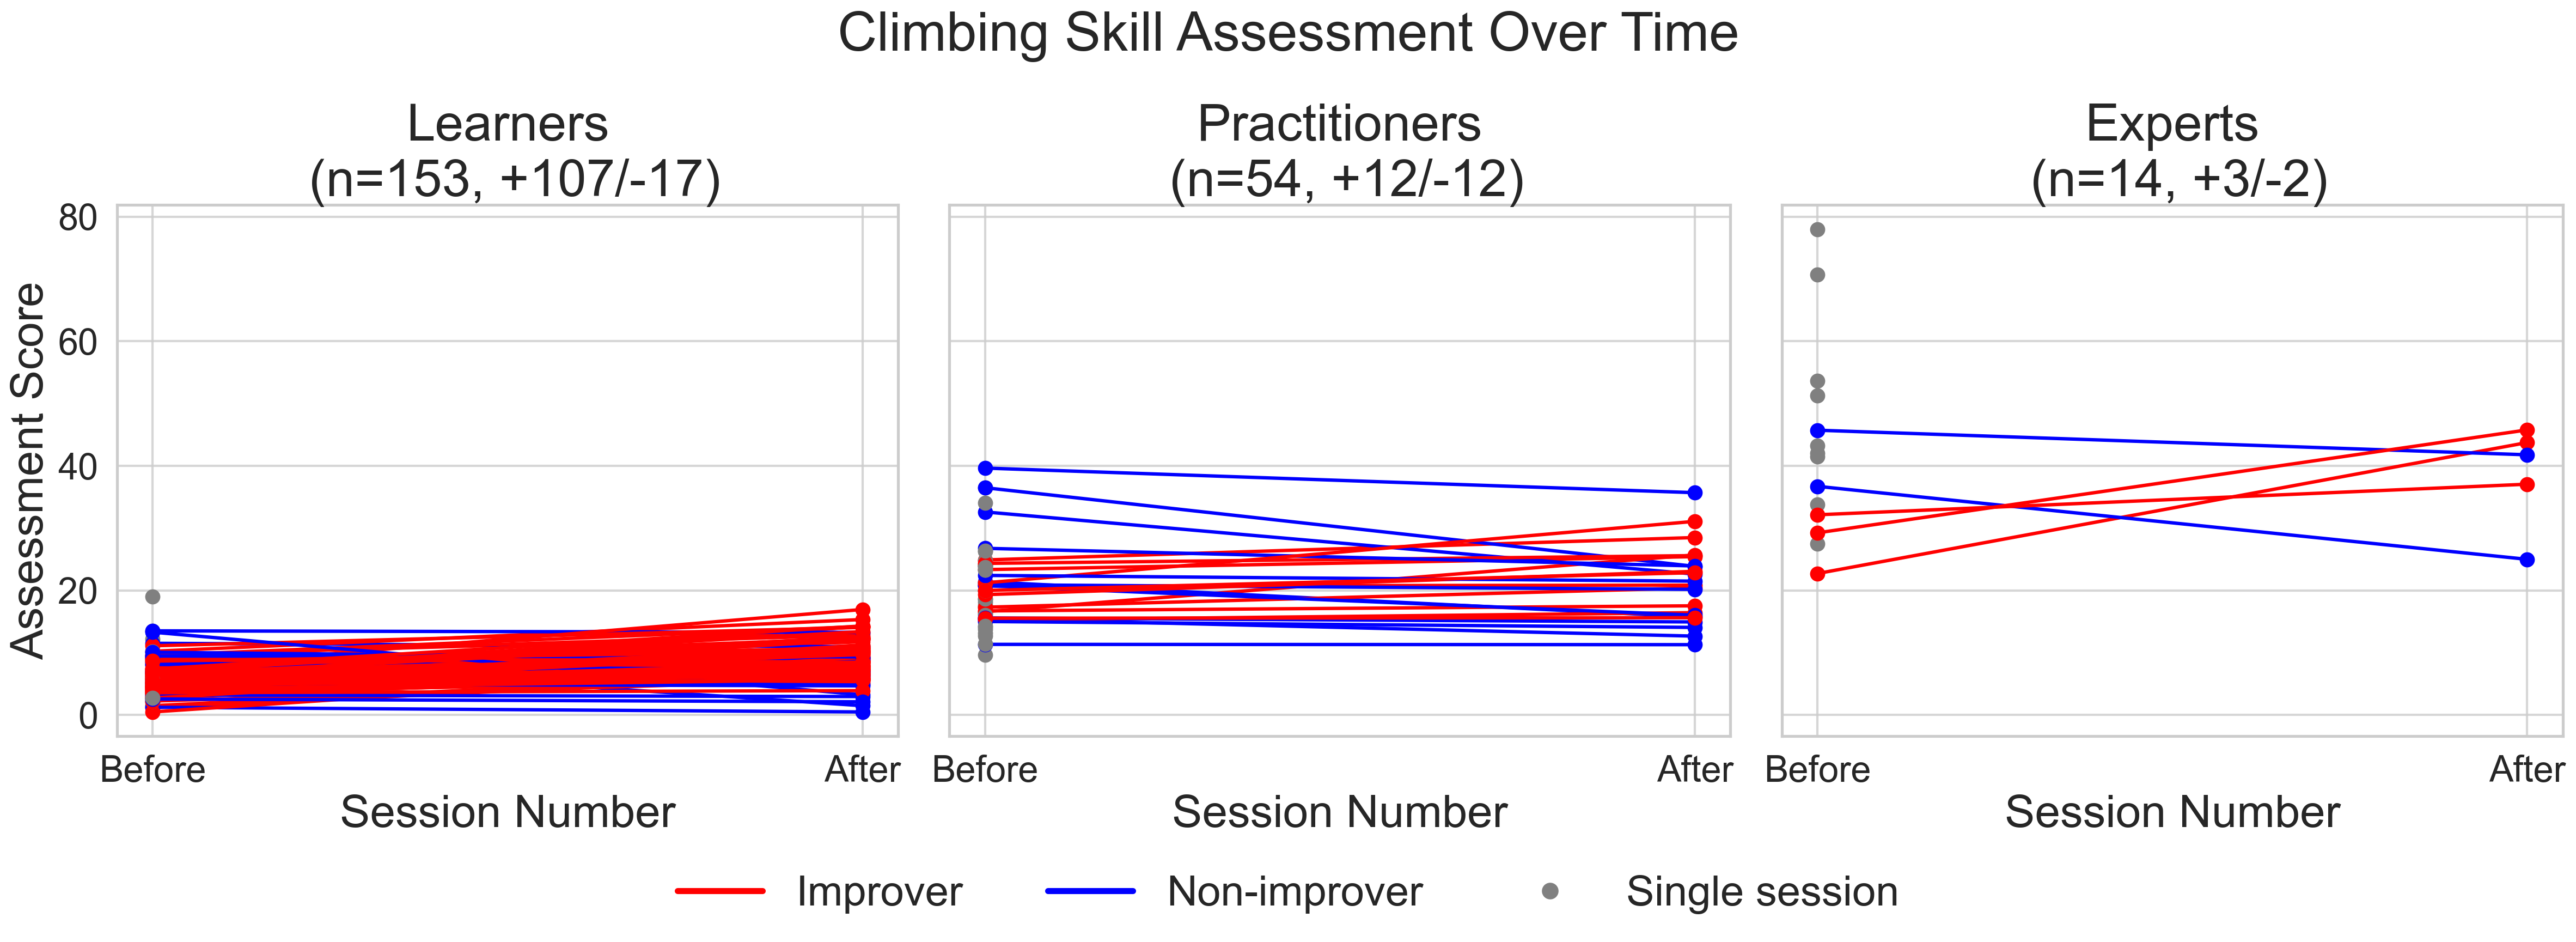

In [63]:
import matplotlib.pyplot as plt
import seaborn as sns

from athletes_brain.fig1.config import savefig_nice

fig, axes = plt.subplots(1, 3, figsize=(24, 8), sharey=True, sharex=True)

conditions_vis = {"Learning": "Learners", "Control": "Practitioners", "Professional": "Experts"}

for cond, ax in zip(["Learning", "Control", "Professional"], axes):
    d = skill_assessment_full[skill_assessment_full["condition"] == cond]
    d = d[d["session_number"] <= 3]
    n_imporvers = 0
    n_non_improvers = 0
    for subject_code in d["subject_code"].unique():
        d_sub = d[d["subject_code"] == subject_code]
        if d_sub.shape[0] >= 2:
            color = (
                "red"
                if d_sub["assessment_score"].iloc[-1] > d_sub["assessment_score"].iloc[0]
                else "blue"
            )
            if color == "red":
                n_imporvers += 1
            else:
                n_non_improvers += 1
            # keep only first and last sessions
            d_sub = d_sub.sort_values(by="session_number").iloc[[0, -1]]
            d_sub["session_number"] = d_sub["session_number"].map({1: 1, 2: 2, 3: 2})

            d_sub["assessment_timedelta"] = (
                d_sub["assessment_timestamp"] - d_sub["assessment_timestamp"].min()
            )
            d_sub["assessment_timedelta"] = d_sub["assessment_timedelta"].dt.days // 30 + 1

        # color is red for improvers, blue for non-improvers
        else:
            color = "gray"
        ax.plot(
            d_sub["session_number"],
            d_sub["assessment_score"],
            marker="o",
            label=subject_code,
            color=color,
            # alpha=0.5,
        )
    title = f"{conditions_vis[cond]}\n (n={d['subject_code'].nunique()}, +{n_imporvers}/-{n_non_improvers})"
    ax.set_title(title, fontsize=34)
    ax.set_xlabel("Session Number", fontsize=30)
    axes[0].set_ylabel("Assessment Score", fontsize=30)
    # if cond == "Learning":
    #     ax.set_xticks([1, 2, 3])
    #     ax.set_xticklabels([1, 2, 3])
    # else:
    ax.set_xticks([1, 2])
    ax.set_xticklabels(["Before", "After"])
    ax.tick_params(axis="x", labelsize=24)
    ax.tick_params(axis="y", labelsize=24)
# axes[1].legend_.remove()
# create a legend for the entire figure
handles = [
    plt.Line2D([0], [0], color="red", lw=4, label="Improver"),
    plt.Line2D([0], [0], color="blue", lw=4, label="Non-improver"),
    # single should be a point, not a line
    plt.Line2D(
        [0], [0], color="gray", marker="o", label="Single session", linestyle="None", markersize=10
    ),
]


fig.legend(
    handles=handles,
    loc="lower center",
    ncol=3,
    fontsize=28,
    frameon=False,
    bbox_to_anchor=(0.5, -0.1),
)
fig.suptitle("Climbing Skill Assessment Over Time", fontsize=36)
plt.tight_layout()

savefig_nice(fig, output_dir / "skill_assessment_over_time.png", dpi=300)

In [8]:
import math
import numpy as np
import pandas as pd
import statsmodels.formula.api as smf
from statsmodels.stats.multitest import multipletests
from numpy.linalg import LinAlgError
from tqdm import tqdm


def _get_beta_and_vcov(res):
    """
    Return (beta_vec, vcov_mat, names_list) for fixed effects only,
    across MixedLM and OLS (incl. cluster-robust wrappers).
    """
    # Preferred path for MixedLM: use fixed effects only
    fe = getattr(res, "fe_params", None)
    if isinstance(fe, pd.Series):
        P = fe.values.astype(float)
        Vfull = res.cov_params()
        if isinstance(Vfull, pd.DataFrame):
            V = Vfull.loc[fe.index, fe.index].values
        else:
            V = np.asarray(Vfull)[: len(P), : len(P)]
        names = list(fe.index)
        return P, V, names

    # Generic path (OLS etc.)
    P = getattr(res, "params", None)
    V = res.cov_params()
    # names
    try:
        names = list(res.model.exog_names)
    except Exception:
        names = None

    if isinstance(P, pd.Series):
        names = list(P.index) if names is None else names
        P = P.values.astype(float)
    else:
        P = np.asarray(P, dtype=float).ravel()
        if names is None:
            names = [f"x{i}" for i in range(len(P))]

    V = V.values if isinstance(V, pd.DataFrame) else np.asarray(V, dtype=float)
    return P, V, names


def lincom(res, coefs, *, warn_missing=False):
    """
    Linear combo on a statsmodels result.
    coefs: dict {param_name: weight}
    Returns: (est, se, z, p, lo, hi)
    """
    P, V, names = _get_beta_and_vcov(res)
    name_to_idx = {n: i for i, n in enumerate(names)}
    L = np.zeros_like(P, dtype=float)

    missing = []
    for name, w in coefs.items():
        if name in name_to_idx:
            L[name_to_idx[name]] = w
        else:
            missing.append(name)

    if warn_missing and missing:
        print(f"[lincom] Missing params (treated as 0): {missing}\nAvailable: {names}")

    est = float(L @ P)
    var = float(L @ V @ L)
    se = np.sqrt(max(var, 0.0))
    z = est / se if se > 0 else np.nan
    # two-sided normal p:
    p = 2 * 0.5 * math.erfc(abs(z) / np.sqrt(2)) if se > 0 else np.nan
    lo, hi = est - 1.96 * se, est + 1.96 * se
    return est, se, z, p, lo, hi


def add_scaled_covariates(d: pd.DataFrame, metric: str) -> pd.DataFrame:
    d = d.copy()
    # Age: center, then square the centered term
    if "age_at_scan" in d.columns:
        d["age_c"] = d["age_at_scan"] - d["age_at_scan"].mean()
        d["age_c2"] = d["age_c"] ** 2
    else:
        d["age_c"] = d["age_c2"] = 0.0

    # TIV: z-score if present and used for 'vol' metrics
    if "tiv" in d.columns and "vol" in str(metric).lower():
        sd = d["tiv"].std(ddof=0)
        d["tiv_z"] = (d["tiv"] - d["tiv"].mean()) / (sd if sd and sd > 0 else 1.0)
    # else:
    #     d["tiv_z"] = 0.0

    return d

In [64]:
import numpy as np, pandas as pd, statsmodels.formula.api as smf
from statsmodels.stats.multitest import multipletests


# 1) assessment slope (score/month) per subject using all available pre/mid/post
def assess_slope_pm(
    d, sub="subject_code", tcol="assessment_timestamp", ycol="assessment_score", tp="tp_label"
):
    x = d[[sub, tcol, ycol, tp]].dropna().copy()
    x[tcol] = pd.to_datetime(x[tcol])
    x = x.sort_values([sub, tcol])
    base = x.groupby(sub)[tcol].transform("min")
    x["months"] = (x[tcol] - base).dt.days / 30.4375
    rows = []
    for sid, g in x.groupby(sub):
        if g.shape[0] < 2:
            continue
        X = np.c_[np.ones(len(g)), g["months"].values]
        beta = np.linalg.lstsq(X, g[ycol].astype(float).values, rcond=None)[0]
        rows.append({sub: sid, "assess_slope_pm": float(beta[1])})
    return pd.DataFrame(rows)


# 2) GM Δ per month per ROI (pre/post)
def gm_delta_pm(
    d,
    sub="subject_code",
    roi="index",
    tcol="scan_dt",
    ycol="y",
    tp="tp_label",
    age="age_at_scan",
    sex="sex",
    tiv="tiv",
):
    x = d[[sub, roi, tcol, ycol, tp, age, sex, tiv]].copy()
    x[tcol] = pd.to_datetime(x[tcol])
    x = x[x[tp].isin(["pre", "post"])].sort_values([sub, roi, tcol])
    x = x.drop_duplicates([sub, roi, tp], keep="first")
    piv = x.pivot_table(
        index=[sub, roi], columns=tp, values=[ycol, tcol, age, sex, tiv], aggfunc="first"
    )
    if "pre" not in piv[ycol].columns or "post" not in piv[ycol].columns:
        return pd.DataFrame(columns=[sub, roi])
    out = pd.DataFrame(
        {
            sub: [i[0] for i in piv.index],
            roi: [i[1] for i in piv.index],
            "gm_pre": piv[ycol]["pre"],
            "gm_post": piv[ycol]["post"],
            "scan_pre": piv[tcol]["pre"],
            "scan_post": piv[tcol]["post"],
            "age_pre": piv[age]["pre"],
            "sex": piv[sex]["pre"],
            "tiv_pre": piv[tiv]["pre"],
        }
    )
    out["months_between"] = (out["scan_post"] - out["scan_pre"]).dt.days / 30.4375
    out["gm_delta_pm"] = (out["gm_post"] - out["gm_pre"]) / out["months_between"]
    return out


# 3) Merge and run ROI-wise OLS with HC3
def relate_delta(gm_pairs, assess_slopes, learners_only=True, group_col="condition"):
    d = gm_pairs.merge(assess_slopes, on="subject_code", how="inner")
    if learners_only and group_col in d.columns:
        d = d[d[group_col].astype(str).str.lower().str.contains("learn")]
    rows = []
    for r, g in d.groupby("index"):  # ROI column
        z = g.replace([np.inf, -np.inf], np.nan).dropna(
            subset=[
                "gm_delta_pm",
                "assess_slope_pm",
                "gm_pre",
                "age_pre",
                "months_between",
                "sex",
                "tiv_pre",
            ]
        )
        if len(z) < 10:
            rows.append({"index": r, "n": len(z), "status": "skip_n<10"})
            continue
        z["sex"] = z["sex"].astype("category")
        m = smf.ols(
            "gm_delta_pm ~ assess_slope_pm + gm_pre + age_pre + months_between + C(sex) + tiv_pre",
            data=z,
        ).fit(cov_type="HC3")
        rows.append(
            {
                "index": r,
                "n": len(z),
                "beta_assess": m.params.get("assess_slope_pm", np.nan),
                "se_assess": m.bse.get("assess_slope_pm", np.nan),
                "t_assess": m.tvalues.get("assess_slope_pm", np.nan),
                "p_assess": m.pvalues.get("assess_slope_pm", np.nan),
            }
        )
    res = pd.DataFrame(rows)
    mask = res["p_assess"].notna()
    if mask.any():
        res.loc[mask, "q_assess"] = multipletests(res.loc[mask, "p_assess"], method="fdr_bh")[1]
    return res.sort_values("q_assess", na_position="last")

In [65]:
def put(prefix, coefs, model):
    est, se, z, p, lo, hi = lincom(model, coefs)
    return {
        f"{prefix}_est": est,
        f"{prefix}_se": se,
        f"{prefix}_z": z,
        f"{prefix}_p": p,
        f"{prefix}_lo": lo,
        f"{prefix}_hi": hi,
    }

In [66]:
# ---- helpers you already have (or paste from earlier message) ----
def assess_slope_pm(
    assess_long: pd.DataFrame,
    sub="subject_code",
    tcol="assessment_timestamp",
    ycol="assessment_score",
):
    x = assess_long[[sub, tcol, ycol]].dropna().copy()
    x[tcol] = pd.to_datetime(x[tcol], errors="coerce")
    x = x.sort_values([sub, tcol])
    base = x.groupby(sub)[tcol].transform("min")
    x["months"] = (x[tcol] - base).dt.days / 30.4375
    rows = []
    for sid, g in x.groupby(sub):
        if g.shape[0] < 2:
            continue
        X = np.c_[np.ones(len(g)), g["months"].to_numpy()]
        beta = np.linalg.lstsq(X, g[ycol].astype(float).to_numpy(), rcond=None)[0]
        rows.append({sub: sid, "assess_slope_pm": float(beta[1])})
    return pd.DataFrame(rows)


def gm_pairs_one_roi(tidy_roi: pd.DataFrame):
    """
    From tidy (single ROI), build per-subject pre/post pairs and ΔGM per month,
    plus pre-scan covariates.
    Expects columns: subject_code, tp_label, scan_dt, y, age_at_scan, sex, tiv (optional), condition (optional)
    """
    d = tidy_roi.copy()
    d = d[d["tp_label"].isin(["pre", "post"])].sort_values(["subject_code", "scan_dt"])
    d = d.drop_duplicates(["subject_code", "tp_label"], keep="first")

    piv = d.pivot_table(
        index="subject_code",
        columns="tp_label",
        values=["y", "scan_dt", "age_at_scan", "sex", "tiv", "condition"],
        aggfunc="first",
    )

    if ("pre" not in piv["y"].columns) or ("post" not in piv["y"].columns):
        return pd.DataFrame(columns=["subject_code"])

    out = pd.DataFrame(
        {
            "subject_code": piv.index,
            "gm_pre": piv["y"]["pre"].astype(float),
            "gm_post": piv["y"]["post"].astype(float),
            "scan_pre": piv["scan_dt"]["pre"],
            "scan_post": piv["scan_dt"]["post"],
            "age_pre": piv["age_at_scan"]["pre"] if "age_at_scan" in tidy_roi.columns else np.nan,
            "sex": piv["sex"]["pre"] if "sex" in tidy_roi.columns else np.nan,
            "tiv_pre": piv["tiv"]["pre"] if "tiv" in tidy_roi.columns else np.nan,
            "condition": piv["condition"]["pre"] if "condition" in tidy_roi.columns else np.nan,
        }
    ).reset_index(drop=True)

    out["months_between"] = (
        pd.to_datetime(out["scan_post"]) - pd.to_datetime(out["scan_pre"])
    ).dt.days / 30.4375
    out = out[out["months_between"] > 0].copy()
    out["gm_delta_pm"] = (out["gm_post"] - out["gm_pre"]) / out["months_between"]
    return out


def add_sex_cat(df, col="sex"):
    if col in df.columns:
        try:
            df[col] = df[col].astype("category")
        except Exception:
            pass
    return df

In [132]:
# ---------- your existing prep ----------
from notebooks.learners.roi_prep import (
    PrepConfig,
    prepare_roi_longitudinal,
    prepost_ancova_table,
    delta_change_table,
)
import statsmodels.formula.api as smf
from statsmodels.stats.multitest import multipletests

# Only paired subjects
cfg = PrepConfig(restrict_roles=True, min_scans_per_subject=1)

learners_only = False
include_time = False

results = []
for metric, df in metric_data.items():
    df_climbing = df[df["group"] == config.CLIMBER_GROUP_LABEL]
    df_climbing = df_climbing.merge(
        skill_assessment_full[["scanning_session_id", "assessment_timestamp", "assessment_score"]],
        left_on="session_id",
        right_on="scanning_session_id",
    )
    stats = parcels.copy()
    for i, row in tqdm(stats.iterrows(), total=len(stats), desc=f"Metric {metric}"):
        # if i!= 262:
        #     continue
        region = row[config.REGION_COL]
        df_region = df_climbing[df_climbing[config.REGION_COL] == region]
        tidy = prepare_roi_longitudinal(df_region, cfg)
        d = tidy.drop_duplicates(subset=["subject_code"], keep="first")

        d = add_scaled_covariates(d, metric)
        m = smf.ols("assessment_score ~ y" + " + age_c + age_c2 + C(sex)", data=d).fit()
        value_diff = put("value_diff", {"y": 1}, m)
        stats.loc[i, value_diff.keys()] = value_diff.values()
        lva = put("LvA", {"C(condition, Treatment(reference='Learner'))[T.Athlete]": 1}, m)
        lva_interaction = put(
            "LvA_interaction", {"y:C(condition, Treatment(reference='Learner'))[T.Athlete]": 1}, m
        )
        age = put("age", {"age_c": 1}, m)
        stats.loc[i, lva.keys()] = lva.values()
        stats.loc[i, lva_interaction.keys()] = lva_interaction.values()
        stats.loc[i, age.keys()] = age.values()
        # break
    # multiple comparisons correction
    for pcol in stats.filter(like="_p").columns:
        reject, pvals_corrected, _, _ = multipletests(stats[pcol], alpha=0.05, method="fdr_bh")
        stats[pcol.replace("_p", "_q")] = pvals_corrected
    stats["metric"] = metric
    results.append(stats)
    # break
region_results = pd.concat(results)
#     break
# break

Metric adc: 100%|██████████| 454/454 [00:09<00:00, 50.32it/s]


In [133]:
stats.sort_values("value_diff_p").head(10)["value_diff_q"]

392    0.987594
435    0.987594
340    0.987594
434    0.987594
393    0.987594
132    0.987594
41     0.987594
184    0.987594
391    0.987594
438    0.987594
Name: value_diff_q, dtype: float64

In [ ]:
# # ---------- your existing prep ----------
# from notebooks.learners.roi_prep import (
#     PrepConfig,
#     prepare_roi_longitudinal,
#     prepost_ancova_table,
#     delta_change_table,
# )
# import statsmodels.formula.api as smf
# from statsmodels.stats.multitest import multipletests

# # Only paired subjects
# cfg = PrepConfig(restrict_roles=True, min_scans_per_subject=2)

# learners_only = False
# include_time = False

# results = []
# for metric, df in metric_data.items():
#     df_climbing = df[df["group"] == config.CLIMBER_GROUP_LABEL]
#     df_climbing = df_climbing.merge(
#         skill_assessment[["scanning_session_id", "assessment_timestamp", "assessment_score"]],
#         left_on="session_id",
#         right_on="scanning_session_id",
#     )
#     stats = parcels.copy()
#     for i, row in tqdm(stats.iterrows(), total=len(stats), desc=f"Metric {metric}"):
#         region = row[config.REGION_COL]
#         df_region = df_climbing[df_climbing[config.REGION_COL] == region]
#         tidy = prepare_roi_longitudinal(df_region, cfg)
#         tidy = tidy.drop_duplicates(subset=["subject_code","session_id"], keep="first")
#         d = tidy.loc[tidy["tp_label"].isin(["pre", "post"])].copy()
#         has_both = d.groupby("subject_code")["tp_label"].transform(lambda s2: {"pre","post"}.issubset(set(s2)))
#         d = d[has_both].copy()
#         d_pre = d.drop_duplicates(subset=["subject_code"], keep="first").set_index("subject_code")
#         d_post = d.drop_duplicates(subset=["subject_code"], keep="last").set_index("subject_code")
#         d_diff = d_pre.copy()
#         if learners_only:
#             d_diff = d_diff[d_diff["condition"] == "Learner"]

#         d_diff["value_diff"] = d_post["y"] - d_pre["y"]
#         d_diff["assessment_score"] = d_post["assessment_score"] - d_pre["assessment_score"]
#         d_diff["months_between"] = (pd.to_datetime(d_post["assessment_timestamp"]) - pd.to_datetime(d_pre["assessment_timestamp"])).dt.days / 30.4375
#         d_diff = d_diff.reset_index()
#         d_diff = add_scaled_covariates(d_diff, metric).copy()
#         # scale value_diff and assessment_score
#         d_diff["value_diff"] = (d_diff["value_diff"] - d_diff["value_diff"].mean()) / (d_diff["value_diff"].std(ddof=0) if d_diff["value_diff"].std(ddof=0) > 0 else 1.0)
#         d_diff["assessment_score"] = (d_diff["assessment_score"] - d_diff["assessment_score"].mean()) / (d_diff["assessment_score"].std(ddof=0) if d_diff["assessment_score"].std(ddof=0) > 0 else 1.0)

#         formula = (
#             "assessment_score ~ value_diff * C(condition, Treatment(reference='Learner'))" + " + age_c + age_c2 + C(sex)"
#         )
#         if include_time:
#             formula += " + months_between"
#         if "vol" in metric:
#             formula += " + tiv_z"
#         m = smf.ols(formula, data=d_diff).fit()
#         value_diff = put("value_diff", {"value_diff": 1}, m)
#         stats.loc[i, value_diff.keys()] = value_diff.values()
#         lva = put("LvA", {"C(condition, Treatment(reference='Learner'))[T.Athlete]": 1}, m)
#         lva_interaction = put("LvA_interaction", {"value_diff:C(condition, Treatment(reference='Learner'))[T.Athlete]": 1}, m)
#         stats.loc[i, lva.keys()] = lva.values()
#         stats.loc[i, lva_interaction.keys()] = lva_interaction.values()
#         # break
#     # multiple comparisons correction
#     for pcol in stats.filter(like="_p").columns:
#         reject, pvals_corrected, _, _ = multipletests(stats[pcol], alpha=0.05, method="fdr_bh")
#         stats[pcol.replace("_p","_q")] = pvals_corrected
#     stats["metric"] = metric
#     results.append(stats)
#     # break
# region_results = pd.concat(results)

Metric adc: 100%|██████████| 454/454 [00:13<00:00, 33.00it/s]


In [79]:
# visualize the trend with the most significant interaction term
metric = "gm_vol"
cont = "value_diff"
vis_df = region_results[(region_results["metric"] == metric)].copy()
i = vis_df[f"{cont}_p"].idxmin()
region = vis_df.loc[i, config.REGION_COL]


df = metric_data[metric]
df_climbing = df[df["group"] == config.CLIMBER_GROUP_LABEL]
df_climbing = df_climbing.merge(
    skill_assessment[["scanning_session_id", "assessment_timestamp", "assessment_score"]],
    left_on="session_id",
    right_on="scanning_session_id",
)
df_region = df_climbing[df_climbing[config.REGION_COL] == region]
tidy = prepare_roi_longitudinal(df_region, cfg)
tidy = tidy.drop_duplicates(subset=["subject_code", "session_id"], keep="first")
d = tidy.loc[tidy["tp_label"].isin(["pre", "post"])].copy()
has_both = d.groupby("subject_code")["tp_label"].transform(
    lambda s2: {"pre", "post"}.issubset(set(s2))
)
d = d[has_both].copy()
d_pre = d.drop_duplicates(subset=["subject_code"], keep="first").set_index("subject_code")
d_post = d.drop_duplicates(subset=["subject_code"], keep="last").set_index("subject_code")
d_diff = d_pre.copy()
if learners_only:
    d_diff = d_diff[d_diff["condition"] == "Learner"]
d_diff["value_diff"] = d_post["y"] - d_pre["y"]
d_diff["assessment_score"] = d_post["assessment_score"] - d_pre["assessment_score"]
d_diff["months_between"] = (
    pd.to_datetime(d_post["assessment_timestamp"]) - pd.to_datetime(d_pre["assessment_timestamp"])
).dt.days / 30.4375
d_diff = d_diff.reset_index()
d_diff = add_scaled_covariates(d_diff, metric).copy()
# scale value_diff and assessment_score
d_diff["value_diff"] = (d_diff["value_diff"] - d_diff["value_diff"].mean()) / (
    d_diff["value_diff"].std(ddof=0) if d_diff["value_diff"].std(ddof=0) > 0 else 1.0
)
d_diff["assessment_score"] = (d_diff["assessment_score"] - d_diff["assessment_score"].mean()) / (
    d_diff["assessment_score"].std(ddof=0) if d_diff["assessment_score"].std(ddof=0) > 0 else 1.0
)
d_diff = add_scaled_covariates(d_diff, metric).copy()
d_diff["condition"] = d_diff["condition"].astype("category")
formula = (
    "assessment_score ~ value_diff * C(condition, Treatment(reference='Learner'))"
    + " + age_c + age_c"
) + " + C(sex)"
if include_time:
    formula += " + months_between"
if "vol" in metric:
    formula += " + tiv_z"
m = smf.ols(formula, data=d_diff).fit()
print(m.summary())

                            OLS Regression Results                            
Dep. Variable:       assessment_score   R-squared:                       0.228
Model:                            OLS   Adj. R-squared:                  0.183
Method:                 Least Squares   F-statistic:                     5.078
Date:                Tue, 09 Sep 2025   Prob (F-statistic):           0.000133
Time:                        12:43:04   Log-Likelihood:                -141.83
No. Observations:                 110   AIC:                             297.7
Df Residuals:                     103   BIC:                             316.6
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                                                                         coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------

<Axes: xlabel='condition', ylabel='assessment_score'>

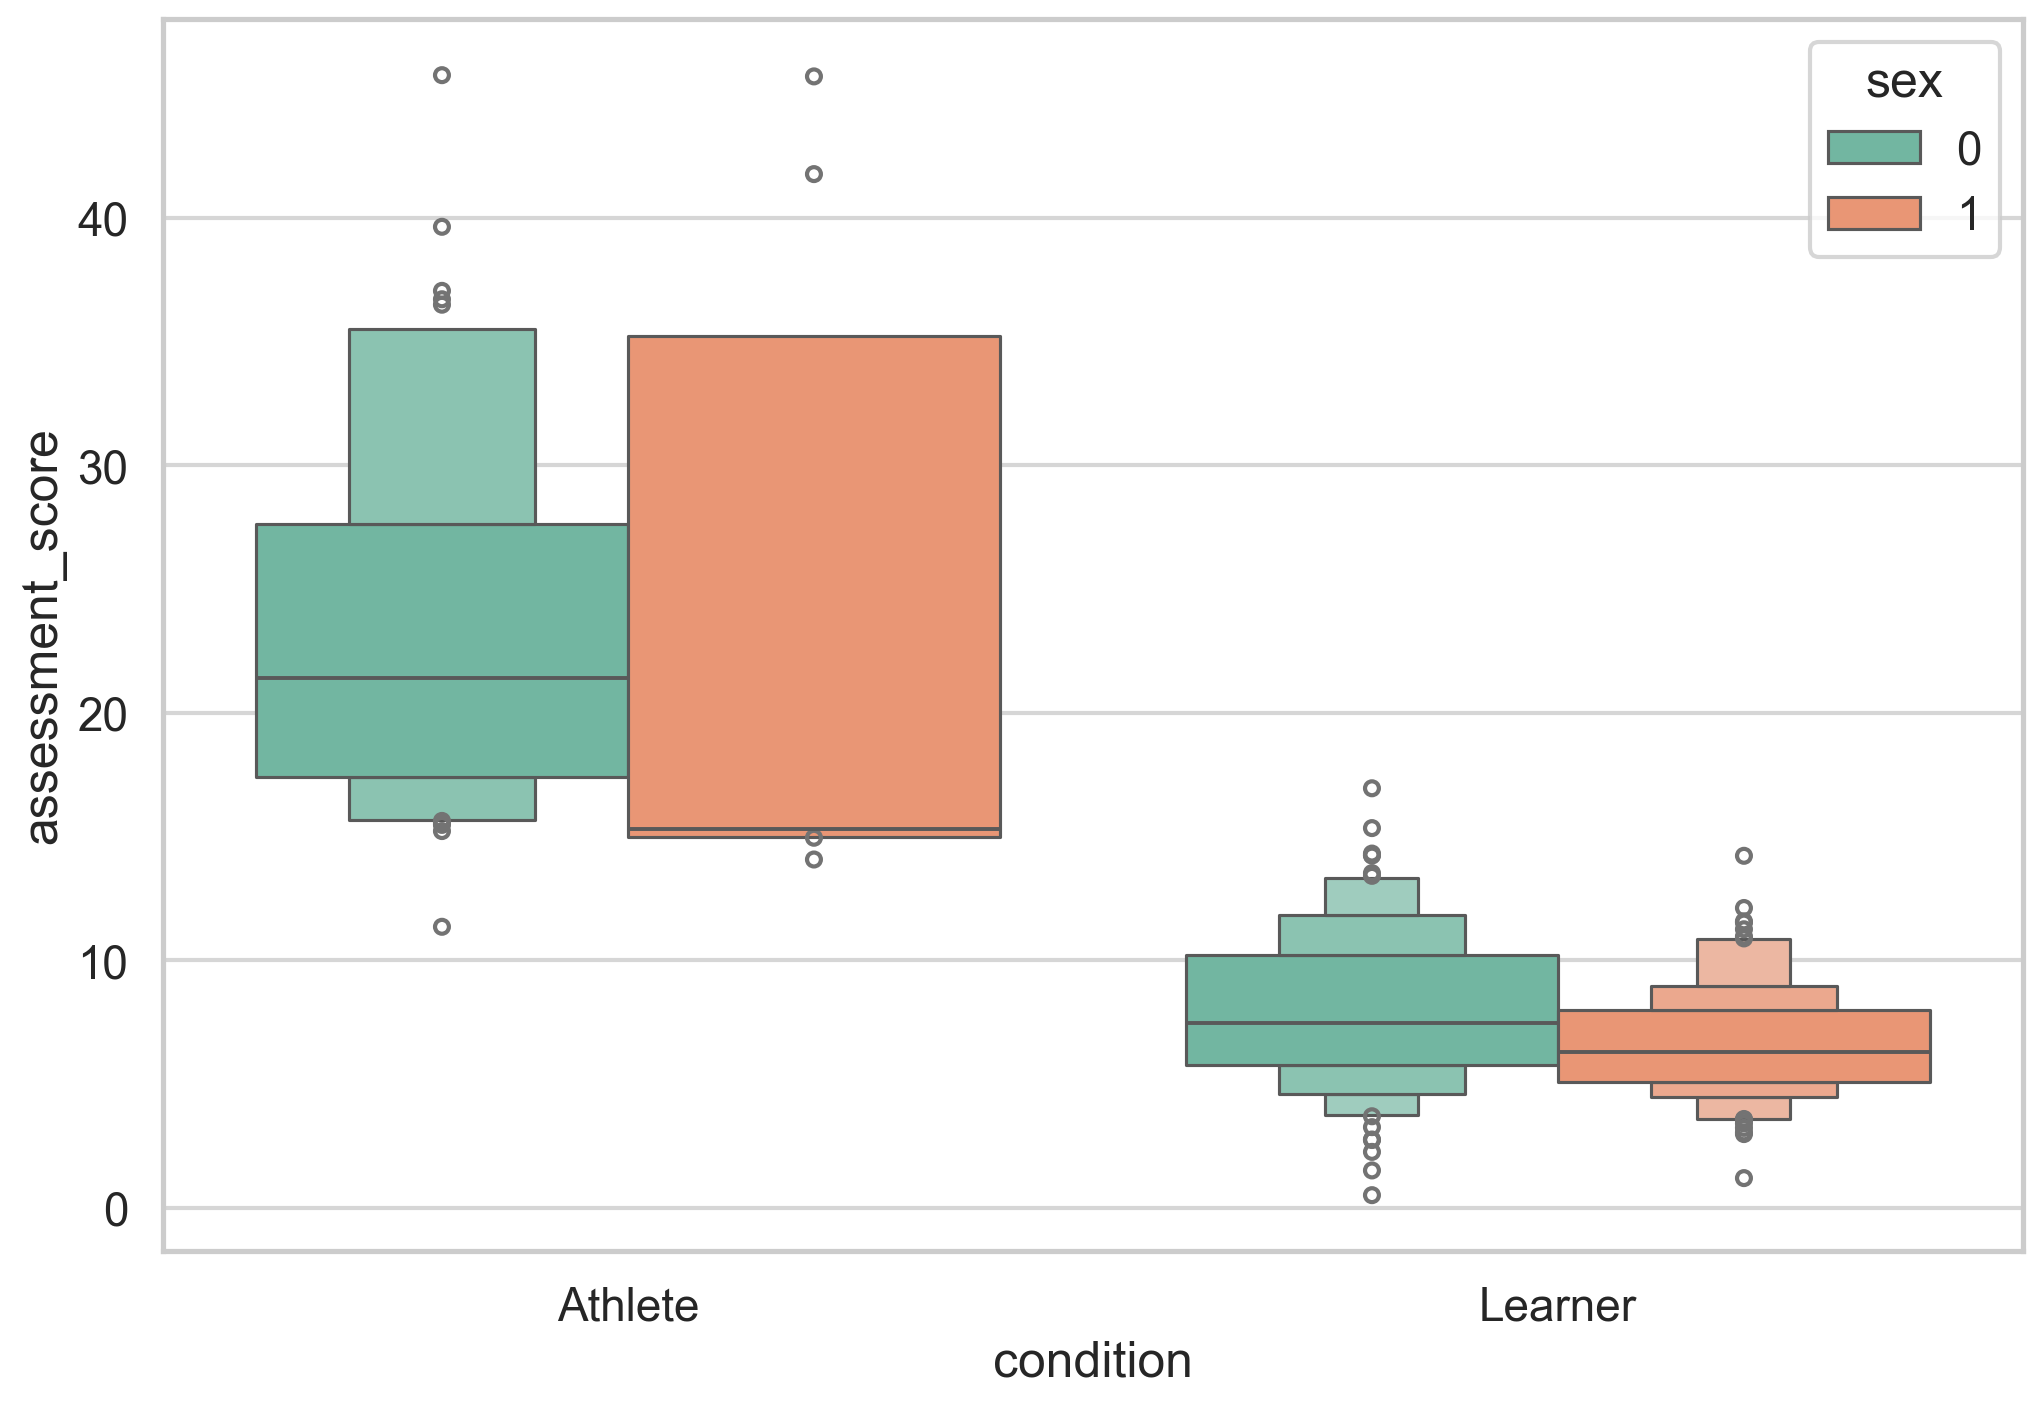

In [77]:
sns.boxenplot(
    data=d,
    x="condition",
    y="assessment_score",
    hue="sex",
    palette="Set2",
)

<Axes: xlabel='y', ylabel='assessment_score'>

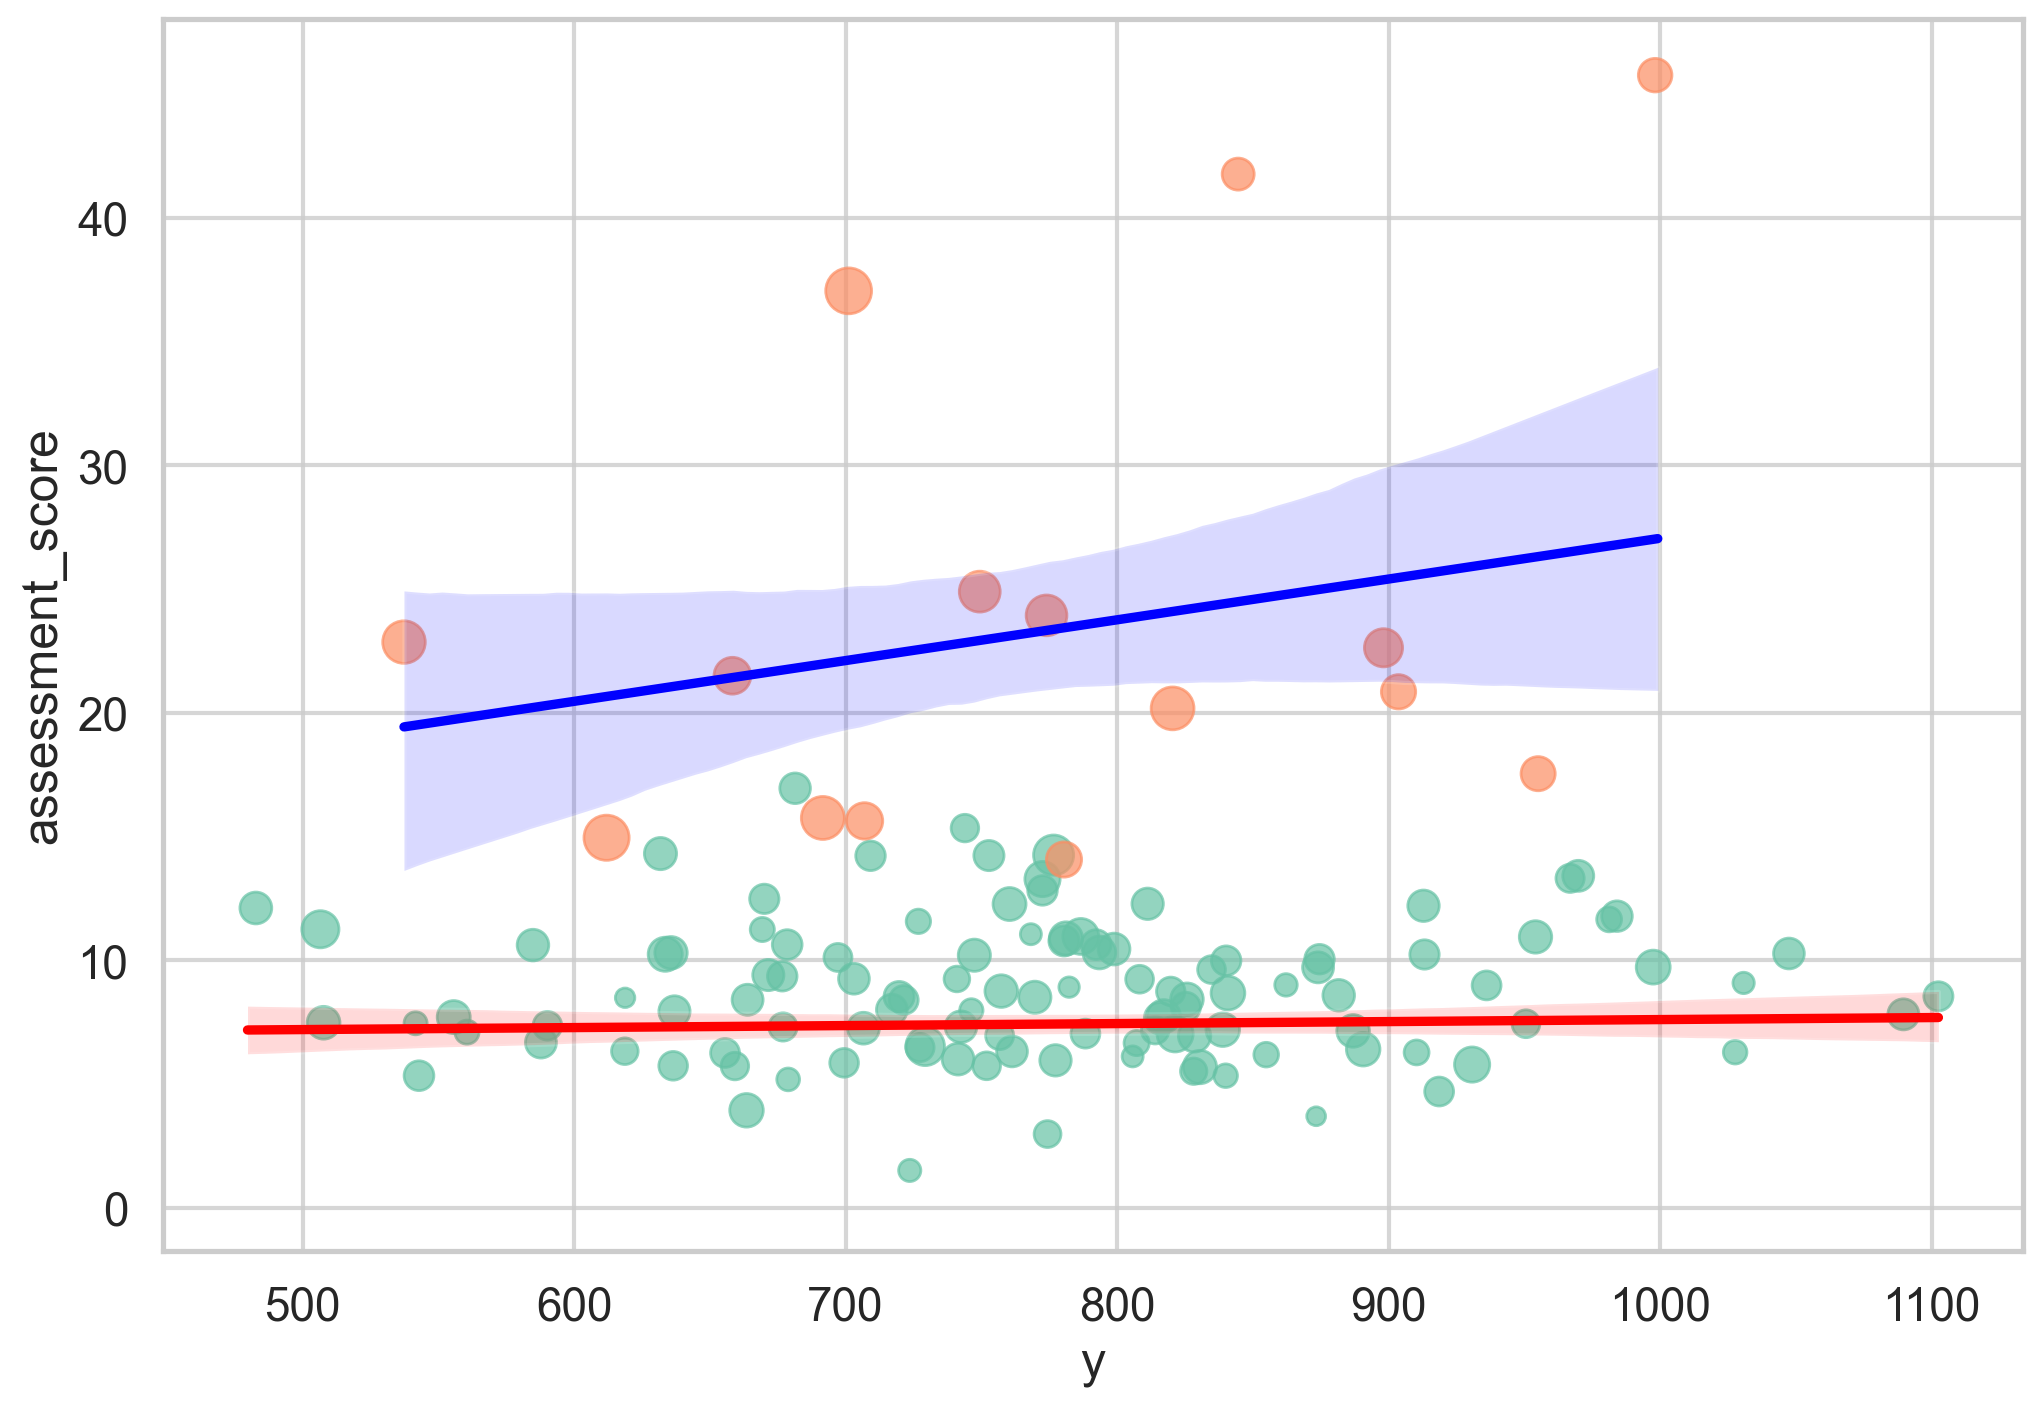

In [78]:
import seaborn as sns

sns.regplot(
    data=d[d["condition"] == "Learner"],
    x="y",
    y="assessment_score",
    scatter_kws={"s": d[d["condition"] == "Learner"]["time_months"] * 50, "alpha": 0.7},
    line_kws={"color": "red"},
)
sns.regplot(
    data=d[d["condition"] == "Athlete"],
    x="y",
    y="assessment_score",
    scatter_kws={"s": d[d["condition"] == "Athlete"]["time_months"] * 50, "alpha": 0.7},
    line_kws={"color": "blue"},
)

In [104]:
import matplotlib.pyplot as plt

# visualize
metrics = ["gm_vol", "adc"]

value_column = "r_partial"
vmin = -5
vmax = 5

fdr_corrected = True
# sport = "all"
old_format = False

# for contrast in ["slope_learner_pre", "factor_learner_pre", "slope","slope_x_learner","factor","factor_x_learner","slope_interaction","factor_interaction","L_post","L_slope_month"]:
for contrast in [
    # "assess_slope",
    # "age",
    # "gm",
    "LvA_interaction",
    "value_diff",
    # "LvA",
]:
    contrast_name = contrast.replace("_p", "_q") if old_format else contrast

    for metric in metrics:
        fdr_label = "fdr_corrected" if fdr_corrected else "uncorrected"
        # metric_dir = output_dir  / "passive" / sport / contrast / metric / fdr_label
        metric_dir = output_dir / metric / contrast / fdr_label
        metric_dir.mkdir(parents=True, exist_ok=True)
        vis_df = region_results[(region_results["metric"] == metric)]

        vis_config = Fig1Config()
        vis_config.VMIN = vmin
        vis_config.VMAX = vmax

        #     break
        # break
        plotter = BrainPlotter(vis_config)

        plotter.plot_single_metric(
            results_df=vis_df,
            metric_key=f"{metric}_{contrast}",
            output_dir=metric_dir,
            p_column=f"{contrast_name}_q" if fdr_corrected else f"{contrast_name}_p",
            value_column=f"{contrast_name}_z",
        )
        plt.close("all")
        # break
    # break
# break

2025-09-09 12:56:07.596 | INFO     | athletes_brain.fig1.brain_visualization:plot_single_metric:276 - Creating brain plots for gm_vol_LvA_interaction
2025-09-09 12:56:07.596 | INFO     | athletes_brain.fig1.brain_visualization:setup_surfaces:30 - Setting up brain surfaces and parcellations
2025-09-09 12:56:07.601 | SUCCESS  | athletes_brain.fig1.brain_visualization:setup_surfaces:39 - Brain surfaces and parcellations loaded successfully
2025-09-09 12:56:07.601 | INFO     | athletes_brain.fig1.brain_visualization:prepare_value_maps:57 - Preparing value maps for LvA_interaction_z
2025-09-09 12:56:07.625 | INFO     | athletes_brain.fig1.brain_visualization:prepare_value_maps:97 - Prepared maps with 200 LH, 200 RH, and 54 subcortical regions
2025-09-09 12:56:07.626 | INFO     | athletes_brain.fig1.brain_visualization:plot_cortical_surface:121 - Creating cortical surface plots
2025-09-09 12:56:07.641 | INFO     | athletes_brain.fig1.brain_visualization:plot_cortical_surface:143 - Plotting l

In [ ]:
stats.sort_values("LvA_interaction_p").head(10)

,index,name,base_name,Label Name,network,component,hemisphere,LvA_est,LvA_se,LvA_z,...,LvA_interaction_hi,value_diff_est,value_diff_se,value_diff_z,value_diff_p,value_diff_lo,value_diff_hi,LvA_q,LvA_interaction_q,value_diff_q
358,359,7Networks_RH_Cont_Cing_2,7networks_rh_cont_cing,7Networks_RH_Cont_Cing,control,cingulate,R,1.038945,0.891698,1.165131,...,-0.211738,0.283897,0.046868,6.057431,1.383130e-09,0.192037,0.375758,0.245589,2.870384e-07,3.139704e-07
246,247,7Networks_RH_SomMot_17,7networks_rh_sommot,7Networks_RH_SomMot,somatomotor,somatomotor,R,3.850100,0.792108,4.860572,...,-0.095237,0.148444,0.023779,6.242727,4.300083e-10,0.101838,0.195051,0.000078,1.395964e-05,1.952238e-07
138,139,7Networks_LH_Cont_PFCl_5,7networks_lh_cont_pfcl,7Networks_LH_Cont_PFCl,control,lateral prefrontal cortex,L,3.188063,0.821579,3.880412,...,-0.108130,0.175372,0.031120,5.635274,1.747807e-08,0.114376,0.236368,0.000277,1.395964e-05,1.786240e-06
393,394,7Networks_RH_Default_pCunPCC_3,7networks_rh_default_pcunpcc,7Networks_RH_Default_pCunPCC,default,precuneus posterior cingulate cortex,R,3.534108,0.798815,4.424189,...,-0.196364,0.336235,0.057471,5.850540,4.899787e-09,0.223592,0.448877,0.000259,2.575287e-05,7.415012e-07
254,255,7Networks_RH_SomMot_25,7networks_rh_sommot,7Networks_RH_SomMot,somatomotor,somatomotor,R,3.059696,0.816627,3.746747,...,-0.090432,0.152047,0.027079,5.614859,1.967225e-08,0.098971,0.205122,0.000348,5.567256e-05,1.786240e-06
381,382,7Networks_RH_Default_PFCdPFCm_4,7networks_rh_default_pfcdpfcm,7Networks_RH_Default_PFCdPFCm,default,dorsal prefrontal cortex medial prefrontal cortex,R,3.029023,0.830762,3.646076,...,-0.055618,0.092711,0.017529,5.289069,1.229403e-07,0.058355,0.127068,0.000453,5.723564e-05,9.302482e-06
343,344,7Networks_RH_Cont_PFCl_4,7networks_rh_cont_pfcl,7Networks_RH_Cont_PFCl,control,lateral prefrontal cortex,R,2.160141,0.885278,2.440071,...,-0.129943,0.228696,0.046026,4.968828,6.735892e-07,0.138485,0.318907,0.015326,1.626862e-04,3.822619e-05
174,175,7Networks_LH_Default_PFC_10,7networks_lh_default_pfc,7Networks_LH_Default_PFC,default,prefrontal cortex,L,3.239732,0.851146,3.806316,...,-0.074945,0.128963,0.028713,4.491486,7.072783e-06,0.072686,0.185240,0.000303,4.764112e-04,2.675870e-04
348,349,7Networks_RH_Cont_PFCl_9,7networks_rh_cont_pfcl,7Networks_RH_Cont_PFCl,control,lateral prefrontal cortex,R,1.832340,0.920278,1.991073,...,-0.103971,0.194388,0.040068,4.851433,1.225728e-06,0.115855,0.272922,0.047201,5.287297e-04,6.183118e-05
43,44,7Networks_LH_SomMot_13,7networks_lh_sommot,7Networks_LH_SomMot,somatomotor,somatomotor,L,2.014317,0.920815,2.187537,...,-0.088698,0.152198,0.034510,4.410255,1.032491e-05,0.084559,0.219838,0.029284,6.075801e-04,3.605778e-04


In [ ]:
import seaborn as sns

m.summary()

# sns.scatterplot(data=d_diff, hue="condition", x="value_diff",y="assessment_score")
# d_diff

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:       assessment_score   R-squared:                       0.163
Model:                            OLS   Adj. R-squared:                  0.106
Method:                 Least Squares   F-statistic:                     2.840
Date:                Mon, 08 Sep 2025   Prob (F-statistic):            0.00954
Time:                        14:27:12   Log-Likelihood:                -281.76
No. Observations:                 110   AIC:                             579.5
Df Residuals:                     102   BIC:                             601.1
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
======================================================================================================
                                         coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------------
Intercept                              0.2901      0.981      0.296      0.768      -1.656       2.237
C(condition)[T.Learner]                3.7476      0.965      3.884      0.000       1.834       5.661
C(sex)[T.1]                           -1.6695      0.903     -1.849      0.067      -3.460       0.121
value_diff                            -0.0017      0.007     -0.228      0.820      -0.016       0.013
value_diff:C(condition)[T.Learner]     0.0048      0.009      0.569      0.571      -0.012       0.022
age_c                                  0.0181      0.070      0.257      0.798      -0.121       0.157
age_c2                                -0.0045      0.006     -0.790      0.431      -0.016       0.007
tiv_z                                 -0.0926      0.439     -0.211      0.833      -0.964       0.779
==============================================================================
Omnibus:                       37.595   Durbin-Watson:                   1.841
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              287.855
Skew:                           0.788   Prob(JB):                     3.11e-63
Kurtosis:                      10.767   Cond. No.                         479.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [ ]:
m

'model'

In [ ]:
import numpy as np
import pandas as pd
from statsmodels.formula.api import mixedlm


m = smf.ols("y ~ C(condition) * assessment_score", data=d_diff).fit()
m.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.007
Model:                            OLS   Adj. R-squared:                 -0.021
Method:                 Least Squares   F-statistic:                    0.2476
Date:                Mon, 08 Sep 2025   Prob (F-statistic):              0.863
Time:                        14:09:34   Log-Likelihood:                -643.70
No. Observations:                 110   AIC:                             1295.
Df Residuals:                     106   BIC:                             1306.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
============================================================================================================
                                               coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------------------
Intercept                                  -36.7480     22.163     -1.658      0.100     -80.689       7.193
C(condition)[T.Learner]                     13.5343     25.894      0.523      0.602     -37.804      64.872
assessment_score                            -1.1557      3.930     -0.294      0.769      -8.948       6.636
C(condition)[T.Learner]:assessment_score     2.4085      5.135      0.469      0.640      -7.773      12.590
==============================================================================
Omnibus:                       32.653   Durbin-Watson:                   1.749
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               77.181
Skew:                          -1.118   Prob(JB):                     1.74e-17
Kurtosis:                       6.440   Cond. No.                         22.6
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""